In [43]:
!pip install langchain langchain_together langchain_chroma chromadb pypdf langchain_community

In [44]:
import os
os.environ["TOGETHER_API_KEY"] = "Your-API-Key"

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]="Your-API-Key"
os.environ["LANGCHAIN_PROJECT"]="advanced-rag"

In [45]:
from langsmith import Client

client = Client()

# LLM vs Chat Model

In [46]:
from langchain_together import Together,ChatTogether

## LLMs

In [47]:
llm = Together(
    model = "meta-llama-llama-2-70b-hf",
    max_tokens= 50
  )

In [48]:
llm.invoke("Answer in one word(yes or no). Cow's milk is green in color")

'.\nQ. 10. Answer in one word(yes or no). The sun is a star.\nQ. 11. Answer in one word(yes or no). The earth is a planet.\nQ. 1'

## Chat models

In [49]:
chat_model = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo")

In [50]:
chat_model.invoke("Answer in detail. Cow's milk is green in color")

AIMessage(content="That statement is not accurate. Cow's milk is not green in color. In fact, cow's milk is typically white or slightly off-white in color. The color of milk can vary slightly depending on factors such as the breed of cow, the quality of the milk, and the level of fat content. However, green is not a common or natural color for cow's milk.\n\nThere are several reasons why cow's milk appears white:\n\n1. **Casein and fat content**: Milk contains a mixture of casein (a protein) and fat molecules. These molecules scatter light in a way that gives milk its white appearance. The casein molecules are particularly effective at scattering shorter wavelengths of light, such as blue and violet, which is why milk often appears white or slightly yellowish.\n2. **Lactose and water content**: Milk is primarily composed of water (around 87%) and lactose (a sugar). The water and lactose molecules also contribute to the white color of milk by scattering light.\n3. **Riboflavin content**

## Chat models output needs to be parsed

In [51]:
from langchain_core.output_parsers import StrOutputParser

In [52]:
simple_chain = chat_model | StrOutputParser()

In [53]:
simple_chain.invoke("Answer in one word(yes or no). Cow's milk is green in color")

'No.'

# Setting up a simple Naive RAG chain

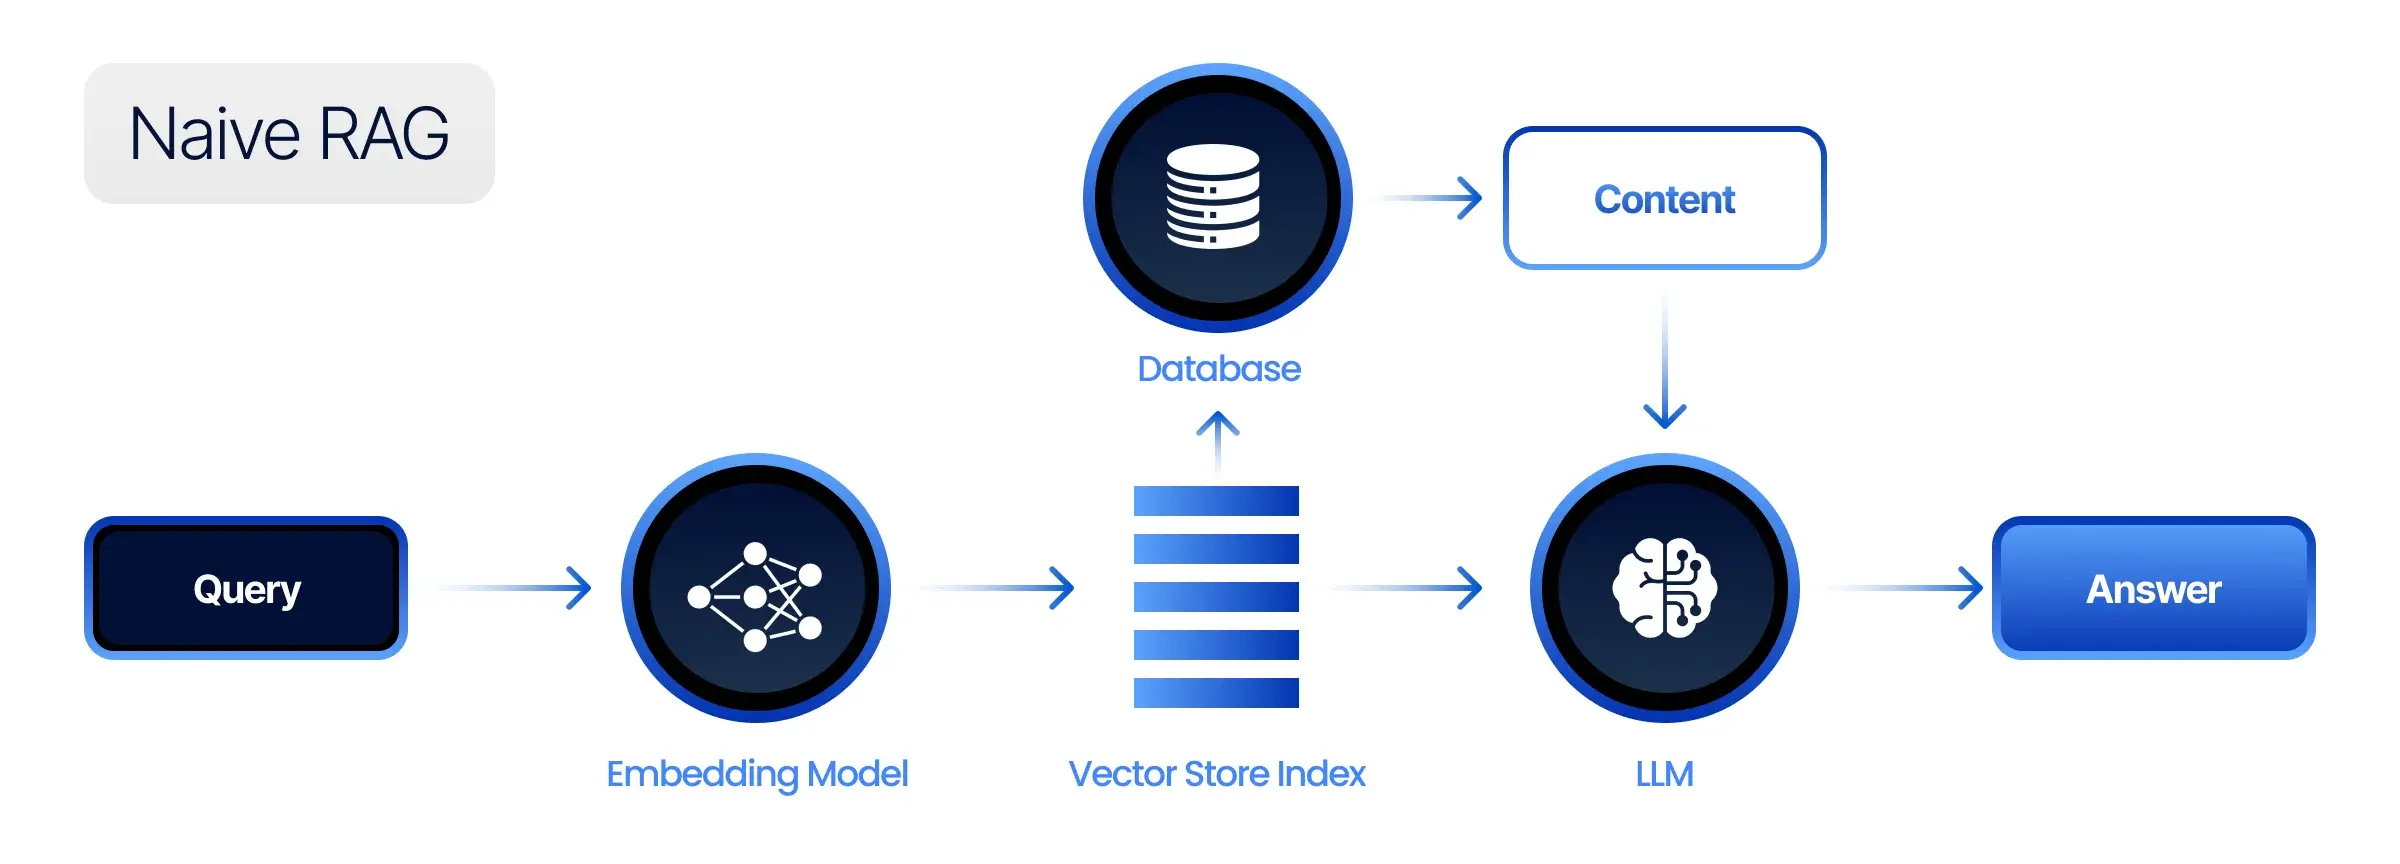

In [54]:
simple_chain.invoke("What is FFCS?")

"FFCS can refer to different things depending on the context. Here are a few possible meanings:\n\n1. **Family and Friends of Convicts and Caring Supporters**: FFCS is an organization that provides support to families and friends of people who are incarcerated.\n2. **Fellowship of Faith Christian School**: FFCS is a private Christian school that provides education to students from kindergarten to high school.\n3. **Fort Frances Canadian Shield**: FFCS could be an abbreviation for a sports team or organization in Fort Frances, Ontario, Canada.\n4. **Flexible Fuel Conversion System**: FFCS is a technology that allows vehicles to run on multiple types of fuel, such as gasoline, ethanol, or biodiesel.\n5. **Federal Financial Credit System**: FFCS could be a system used by the US government to manage financial transactions and credit.\n\nWithout more context, it's difficult to determine which definition is most relevant. If you have more information or clarification about the FFCS you're re

## Loading a PDF file

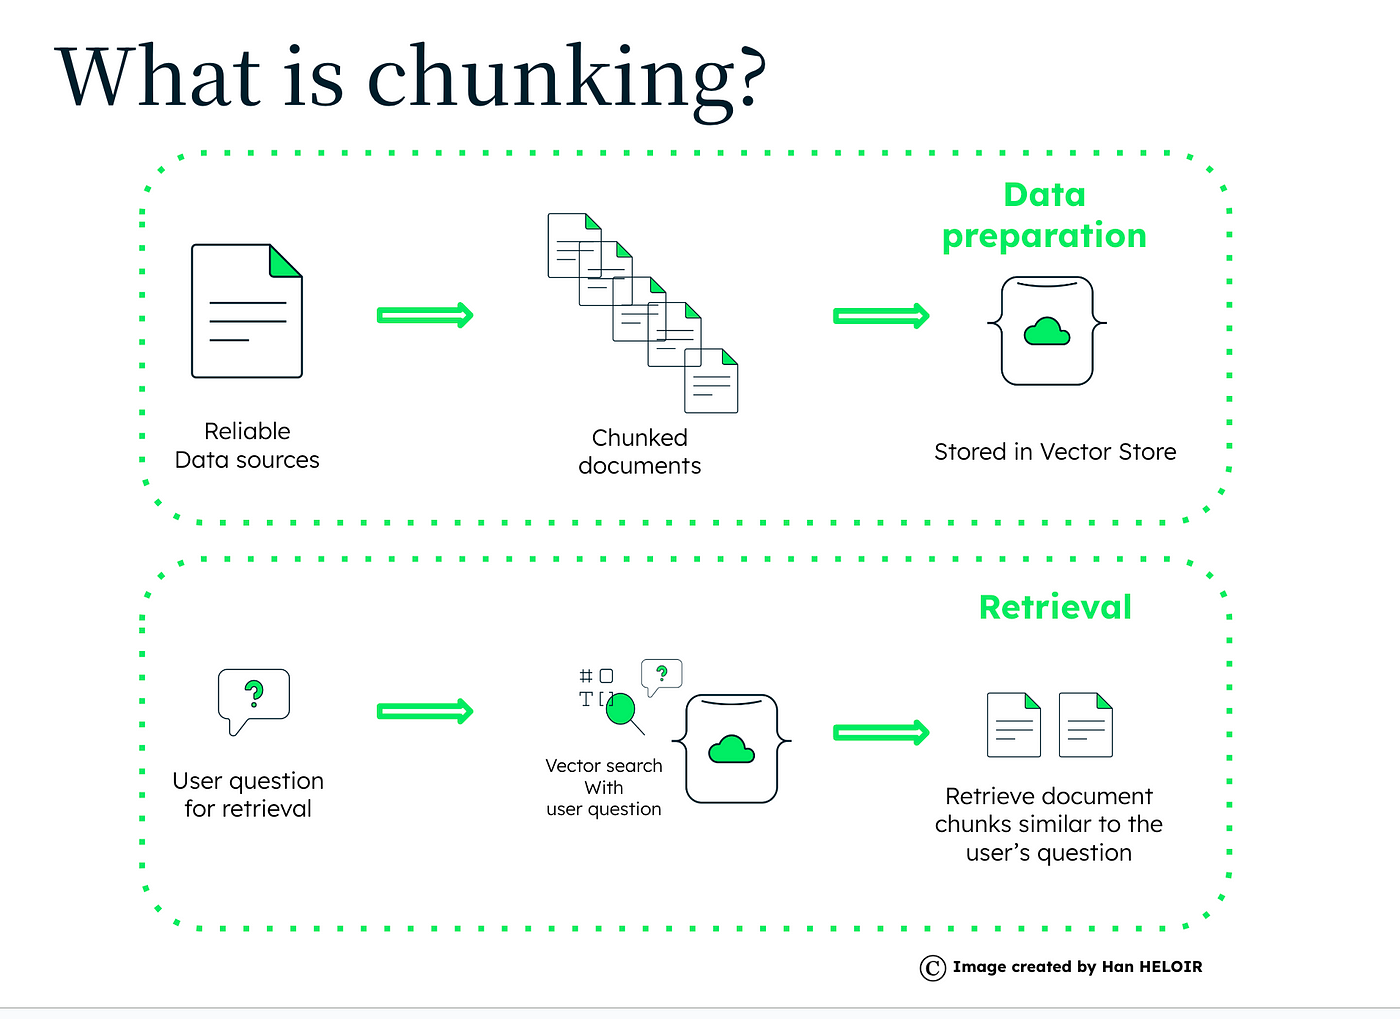

In [55]:
from langchain_community.document_loaders import PyPDFLoader

In [56]:
loader = PyPDFLoader("/content/small.pdf",)

In [57]:
docs = loader.load()

In [58]:
len(docs)

3

In [59]:
docs[1]

Document(metadata={'producer': 'cairo 1.16.0 (https://cairographics.org)', 'creator': 'PyPDF', 'creationdate': '2025-05-25T20:07:20+05:30', 'source': '/content/small.pdf', 'total_pages': 3, 'page': 1, 'page_label': '2'}, page_content='which will help the student to develop additional skills.\n7. Important courses are offered in both semesters, which will help the students to re-\nregister the course and clear the backlog in the subsequent semester. This will help the\nslow learners.\n8. Provisions are there for academically sound students  to carry out research activities\nin their UG Programme.\n9. FFCS offers not only wide choice of courses  for students to build their own \ncurriculum, but also enhances their skill in planning. \n10. A Proctor / faculty advisor helps the student in identifying the courses to be \nstudied in each semester based on programme requirement, course prerequisites, \nstudent’s academic ability and interest in various disciplines, past academic history, \npr

## Splitting it into chunks

In [60]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [61]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
)

In [62]:
chunks = text_splitter.split_documents(docs)

In [63]:
len(chunks)

11

In [64]:
chunks[10]

Document(metadata={'producer': 'cairo 1.16.0 (https://cairographics.org)', 'creator': 'PyPDF', 'creationdate': '2025-05-25T20:07:20+05:30', 'source': '/content/small.pdf', 'total_pages': 3, 'page': 2, 'page_label': '3'}, page_content='3D-iD Studio with 30 iMacs, Smart PD Lab, Ergonomics Lab, and\nPainting Booth are some more facilities already established.Our\nprogrammes would encourage contemporary design thinking and would\ngive a wider perspective to the thoughts and ideas of tomorrow. Our\nprogrammes aim at developing skills, knowledge and aptitude among\nstudents so that they can bring about innovation in the product\nmanufacturing industry. The students are trained to approach product\ndesign from a holistic viewpoint - integrating the aesthetics,\nergonomics, and engineering in a balanced and harmonious manner.\nAdmission information for B.Des and M.Des programme - Selection for\nB.Des programme is based on  a  valid UCEED score or  V-DAT(Design\nAptitude  Test) score  with  10+

## Creating embeddings and setting up a vectorstore

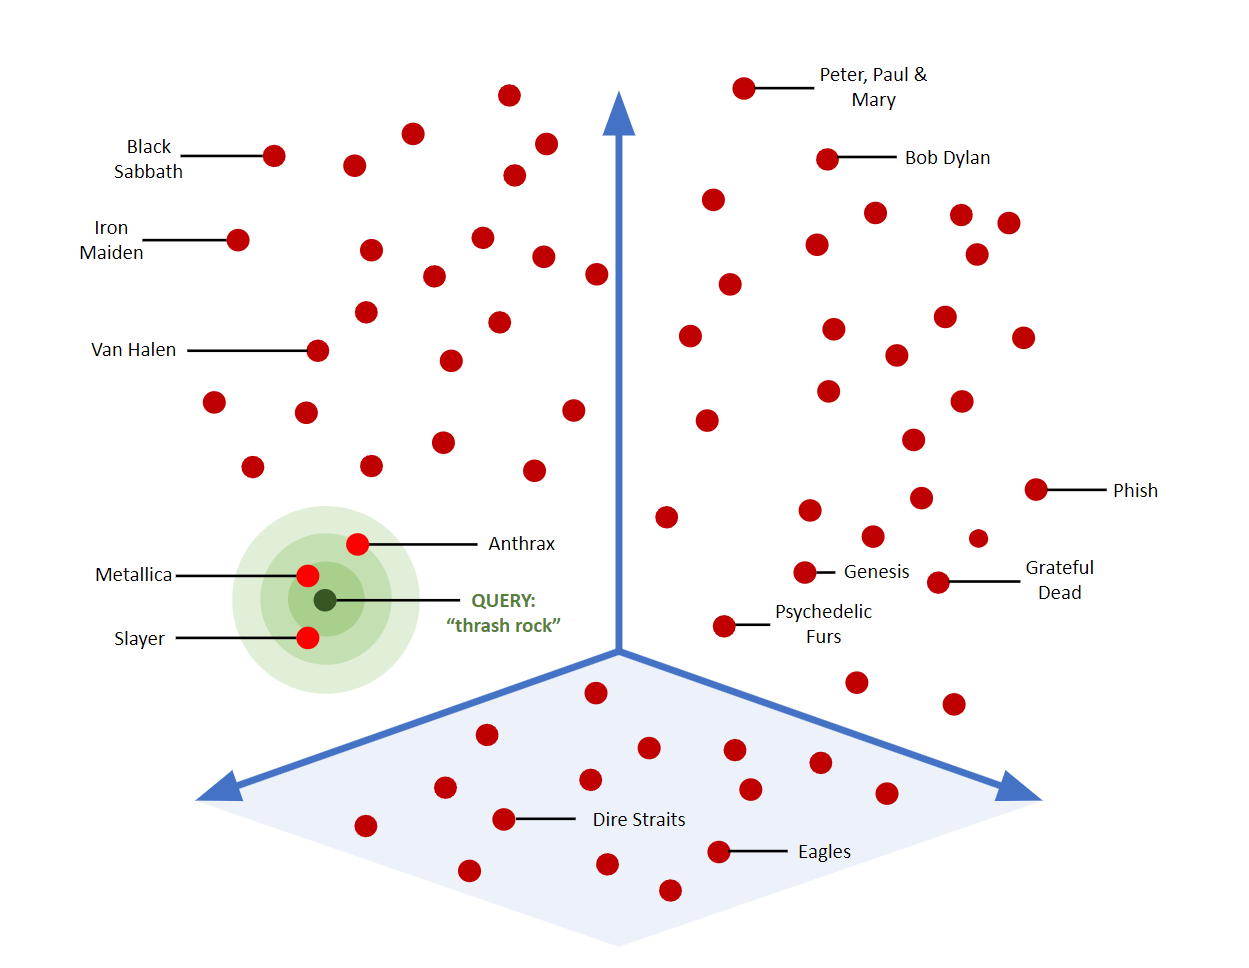

In [65]:
from langchain_together import TogetherEmbeddings

In [66]:
embeddings = TogetherEmbeddings(model="BAAI/bge-base-en-v1.5",)

In [67]:
import chromadb

In [68]:
persistent_client = chromadb.PersistentClient(path="/content/vectorstore")

In [69]:
persistent_client.get_or_create_collection("my_collection")

Collection(name=my_collection)

In [70]:
from langchain_chroma import Chroma

In [71]:
vector_store_from_client = Chroma(
    client=persistent_client,
    collection_name="my_collection",
    embedding_function=embeddings,
)

In [72]:
retriever = vector_store_from_client.as_retriever()

In [73]:
retriever.add_documents(chunks)

['b2e3bf8b-9ea6-4a6e-93fb-87e40005e515',
 'd77fb35c-959e-404d-b0da-9e1ee6be6a41',
 '9234fc94-0059-415a-bc1a-c554f951bb88',
 '75aa858a-b3e1-49d9-8558-9fb3b51ba515',
 'dc1540b5-e894-41d0-9529-1b1ab96fe667',
 '899bb73f-9456-4715-925c-bbf51b0f06d0',
 '838a1ad0-521e-4ad2-bbbb-7c626f0c6471',
 '17503fdf-4569-4295-89f3-1289610472e8',
 '76c3ba4b-0a36-45e3-b233-769604c80f8d',
 '3084b888-f073-4baf-9c85-6587310e7fd5',
 '5c8403fb-d850-4611-922b-e101d54e8d66']

## Creating a simple RAG Prompt

In [74]:
from langchain_core.prompts import ChatPromptTemplate

In [75]:
prompt = ChatPromptTemplate([
    ("system", """You are a helpful assistant designated
     to answer questions about research papers.
     Your name is Geeno."""),
    ("human", """
    Answer the following user question:
    {query}
    Here are some relevant that might be useful for you in
    aswering the question
    {context}"""),
])

In [76]:
prompt

ChatPromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant designated\n     to answer questions about research papers.\n     Your name is Geeno.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, template='\n    Answer the following user question:\n    {query}\n    Here are some relevant that might be useful for you in\n    aswering the question\n    {context}'), additional_kwargs={})])

## Setting up a naive RAG chain

In [77]:
from langchain_core.runnables import RunnableAssign, RunnableLambda

In [78]:
def retrieve(state):
  query = state["query"]
  results = retriever.invoke(query)
  return " ".join([doc.page_content for doc in results])

In [79]:
chain = (RunnableAssign({"context":RunnableLambda(retrieve)}) |
         prompt |
         chat_model |
         StrOutputParser()
)

In [80]:
chain.invoke({"query":"What is Deep seek R1? explain in short"})

'Hello, I\'m Geeno. Unfortunately, the provided text does not mention "Deep seek R1". It appears to be information about admission procedures and facilities for design and technology programs at a university. If you could provide more context or information about Deep seek R1, I\'d be happy to try and help you understand what it is.'

In [81]:
(chat_model|StrOutputParser()).invoke("What is Deep seek R1? explain in short")

"Deepsea Challenger's submersible, the Deep Seeker (or Deep Seek R1), is not well-known, however, the Deepsea Challenger is. \n\nThe Deepsea Challenger is a deep-diving submersible designed to reach the lowest point in the ocean, the Challenger Deep. It was piloted by filmmaker James Cameron in 2012."

# Advanced RAG Techniques

## Pre-Retrieval Techniques

### Hypothetical Document Embedding

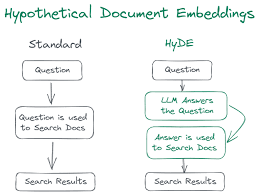

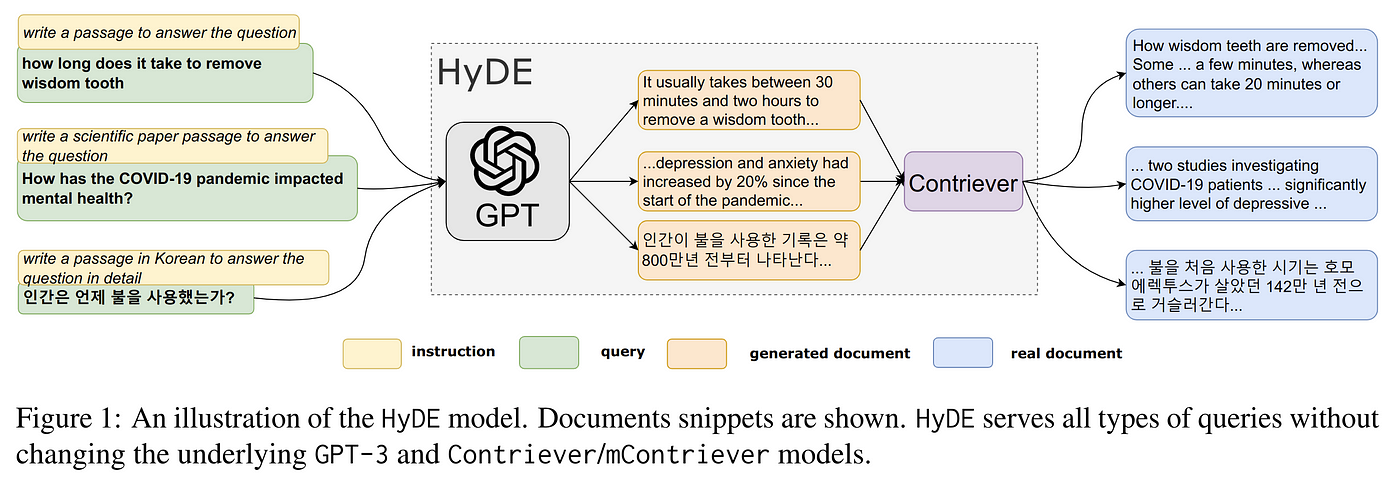

In [82]:
loader = PyPDFLoader("/content/deepseek.pdf",)

In [83]:
docs = loader.load()

In [84]:
len(docs)

22

In [85]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
)

In [86]:
chunks = text_splitter.split_documents(docs)

In [87]:
len(chunks)

73

In [88]:
retriever.add_documents(chunks)

['80cfd979-9946-498b-9482-99b41925f90a',
 'c0f51751-f9cf-4235-9084-4328beab4b5d',
 '8bb7792f-ef84-4a40-8ecb-d92597530c54',
 '2147462f-8ab7-4429-84f2-9c23e6838241',
 '495a1ed3-5197-4f6f-b712-aeff80758e3e',
 '6735167a-e46a-4d52-b258-ecd26c134601',
 'd5d2b4d1-1a56-43b7-9080-19a2086852ba',
 'f7ef1354-939f-4367-9718-6d4afbdfaa03',
 '9e3016eb-2feb-4bc5-bbb3-e124dbd42a1b',
 'd182a099-89e1-4f0e-a028-c3b2356ad64b',
 '0a4a62e9-a208-4c27-a073-8ad3fa56e715',
 '047e0add-49ca-4e71-9a5c-c6ce479e579c',
 'a49aa3e1-506a-4612-8158-83496962b985',
 'b5bc3cd8-a73a-417b-8d7c-46ab2bb50edb',
 '75628979-3c3a-4f9b-8c94-3e89050ea20f',
 '34be9b60-3e94-4082-a00d-29ad2ce42b03',
 '2ff32b24-2722-421d-939e-f6e388a96b3c',
 '4151e70a-23bf-4055-bbea-79ec974e644d',
 '18457b84-9bfe-462e-a1c3-69800f3b83fb',
 '12640f8b-858e-4a57-9e4c-45c34c6354fc',
 '69aceaa1-a923-494d-9720-0cda4235cee9',
 '4641ad23-7440-4a1e-9e15-69007761a574',
 'ef1c6616-1f7e-4bae-8de3-2bb7ffd2be5c',
 '713a3cb6-58c5-4b98-bdc1-0a4abb7c8f3c',
 'cc9c051c-b63a-

In [89]:
hyde_prompt = ChatPromptTemplate([
    ("system", """You are a helpful assistant designated
     to answer questions about research papers.
     Your name is Geeno."""),
    ("human", """
    Answer the following user question:
    {query}
    """),
])

In [90]:
def hyde_retrieve(state):
  query = state["hypothetical_answer"]
  results = retriever.invoke(query)
  return " ".join([doc.page_content for doc in results])

In [91]:
hyde_chain = (
    RunnableAssign({"hypothetical_answer":hyde_prompt|chat_model|StrOutputParser()})|
    RunnableAssign({"context":RunnableLambda(hyde_retrieve)}) |
    prompt |
    chat_model |
    StrOutputParser()
)

In [92]:
pip install -U langchain langchain-openai

In [93]:
hyde_chain.invoke({"query":"What is Deep seek R1? explain in short"})

"Hello, I'm Geeno. DeepSeek-R1 is an advanced AI model that excels in various tasks such as creative writing, question answering, editing, and summarization. It has achieved impressive results on several benchmarks, outperforming other models like DeepSeek-V3 in many areas, including long-context understanding and factual queries. DeepSeek-R1 demonstrates strong reasoning capabilities, thanks to large-scale reinforcement learning, and has a competitive edge in educational tasks."

In [94]:
hyde_chain_with_states = (
    RunnableAssign({"hypothetical_answer":hyde_prompt|chat_model|StrOutputParser()})|
    RunnableAssign({"context": RunnableLambda(hyde_retrieve)}) |
    RunnableAssign({"answer": prompt | chat_model | StrOutputParser()})
)

In [95]:
hyde_chain_with_states.invoke({"query":"What is Deep seek R1? explain in short"})

{'query': 'What is Deep seek R1? explain in short',
 'hypothetical_answer': "Hello, I'm Geeno. DeepSeek R1 is a deep learning-based tool for predicting RNA-RNA interactions, specifically designed to identify binding sites between two RNA molecules. It uses convolutional neural networks (CNNs) to predict these interactions.",
 'context': '• Others: DeepSeek-R1 also excels in a wide range of tasks, including creative writing,\ngeneral question answering, editing, summarization, and more. It achieves an impressive\nlength-controlled win-rate of 87.6% on AlpacaEval 2.0 and a win-rate of 92.3% on Are-\nnaHard, showcasing its strong ability to intelligently handle non-exam-oriented queries.\nAdditionally, DeepSeek-R1 demonstrates outstanding performance on tasks requiring\nlong-context understanding, substantially outperforming DeepSeek-V3 on long-context\nbenchmarks.\n2. Approach\n2.1. Overview\nPrevious work has heavily relied on large amounts of supervised data to enhance model\nperforman

## Step Back Prompting

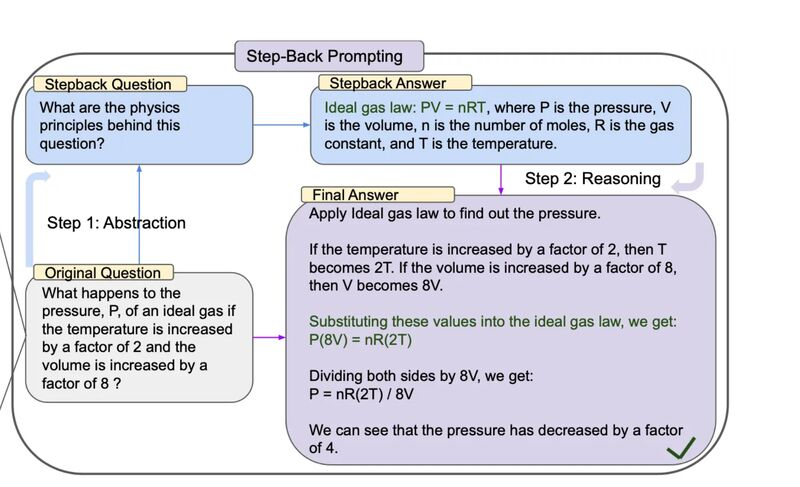

In [96]:
stepback_prompt = ChatPromptTemplate([
    ("system", """You are a helpful assistant."""),
    ("human", """
    Given a user question think of how the problem can be
    decomposed into samaller problems.
    Divide and conquer the problem.
    create a step back question
    and answer it
    here is a user question:
    {query}.
    Your answer should only have a step back question and it's answer.
    """),
])

In [97]:
stepback_prompting_chain = stepback_prompt | chat_model | StrOutputParser()

In [98]:
stepback_prompting_chain.invoke({"query":"""What happens to the
                                            pressure P of a ideal gas when the
                                            Temperature T is increased by afactor of 2
                                            and the volume V is increased by a
                                            factor of 8?"""})

"To approach this problem, let's take a step back and ask: \nWhat is the relationship between pressure (P), temperature (T), and volume (V) of an ideal gas?\n\nThe relationship between these variables is given by the ideal gas law: PV = nRT, where n is the number of moles of gas and R is the gas constant. This equation shows that pressure is inversely proportional to volume and directly proportional to temperature."

In [99]:
prompt1 = ChatPromptTemplate([
    ("system", """You are a helpful assistant designated
     to answer questions.
     Your name is Geeno."""),
    ("human", """
    Answer the following user question:
    {query}
    Here is a stepback question and it's answer provided
    {context}"""),
])

In [100]:
final_chain = (
    RunnableAssign({"context":stepback_prompting_chain}) |
    prompt1 |
    chat_model |
    StrOutputParser()
)

In [101]:
final_chain.invoke({"query":"What happens to the pressure P of a ideal gas when the Temperature T is increased by afactor of 2 and the volume V is increased by a factor of 8?"})

"To determine what happens to the pressure P of an ideal gas when the temperature T is increased by a factor of 2 and the volume V is increased by a factor of 8, we can use the ideal gas law: P = nRT/V.\n\nInitially, the pressure is P = nRT/V.\n\nWhen the temperature T is increased by a factor of 2, the new temperature T' = 2T.\n\nWhen the volume V is increased by a factor of 8, the new volume V' = 8V.\n\nSubstituting these new values into the ideal gas law, we get the new pressure P' = nR(2T)/(8V).\n\nSimplifying this expression, P' = (2nRT)/(8V) = (1/4)(nRT/V).\n\nSince P = nRT/V, we can rewrite this as P' = (1/4)P.\n\nTherefore, when the temperature T is increased by a factor of 2 and the volume V is increased by a factor of 8, the pressure P of the ideal gas decreases to 1/4 of its original value."

## Post Retrieval Stratergies

### Reranking

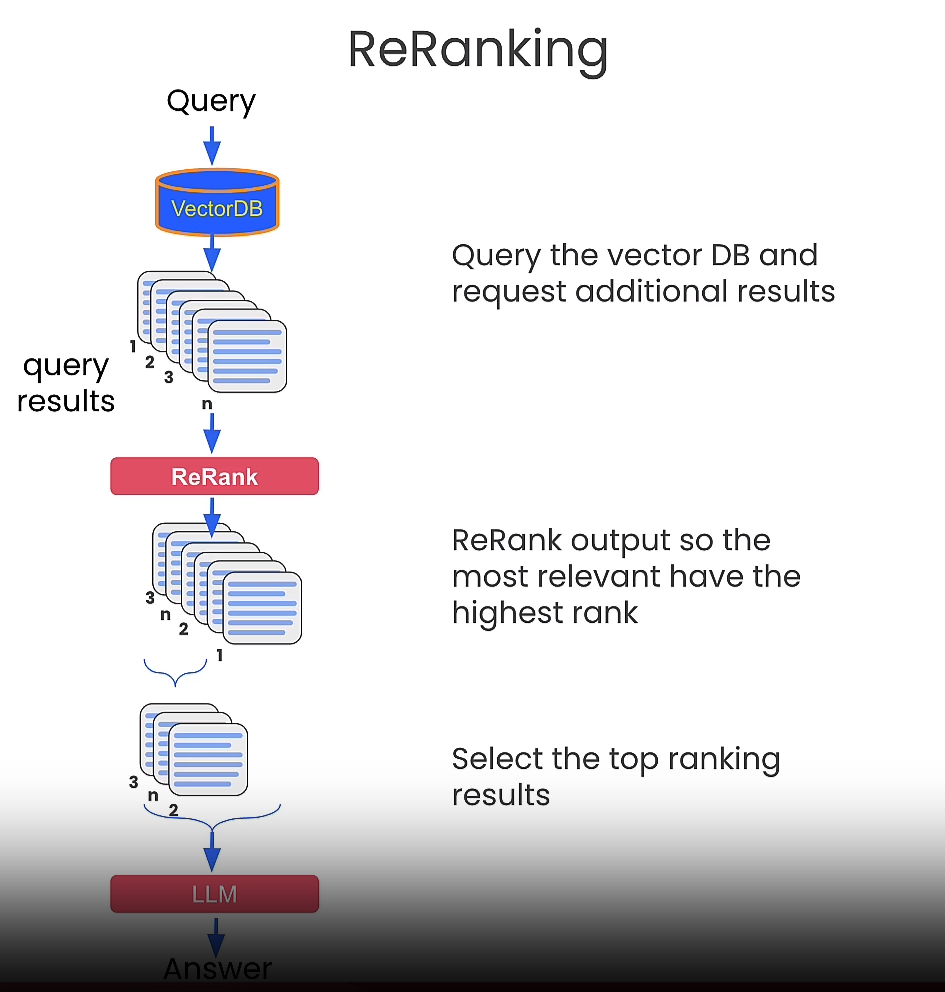

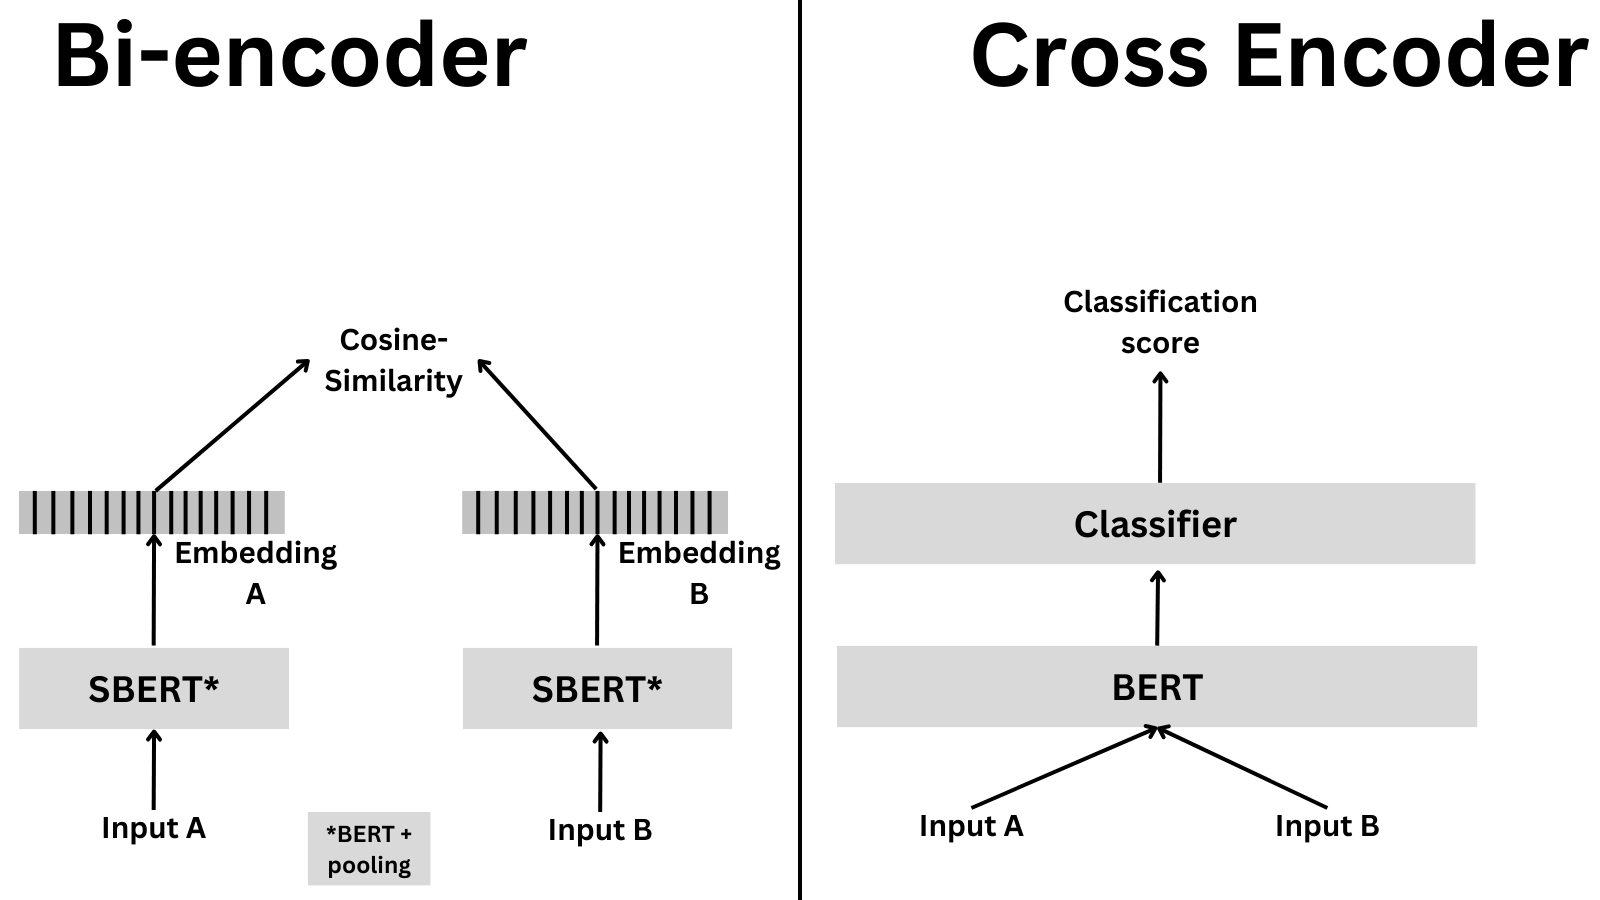

**Run With Caution You will need a GPU to run it!**

In [102]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
compressor = CrossEncoderReranker(model=model, top_n=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

In [103]:
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

In [104]:
def retrieve_and_rerank(state):
  query = state["query"]
  results = compression_retriever.invoke(query)
  return " ".join([doc.page_content for doc in results])

In [105]:
reranking_chain = (RunnableAssign({"context":RunnableLambda(retrieve_and_rerank)}) |
         prompt |
         chat_model |
         StrOutputParser()
)

In [106]:
chain.invoke({"query":"What is Deep seek R1? explain in short"})

"Hello, I'm Geeno. DeepSeek-R1 is a language model that has been fine-tuned using large-scale reinforcement learning (RL) to improve its reasoning capabilities. It is a variant of the DeepSeek model, with a focus on enhancing tasks such as function calling, multi-turn conversations, and complex role-playing. DeepSeek-R1 has shown outstanding performance on various benchmarks, including MMLU, MMLU-Pro, and GPQA Diamond, and excels in tasks like creative writing, general question answering, and long-context understanding. However, it still has limitations, such as language mixing issues and sensitivity to prompts, which are planned to be addressed in future updates."

## Hybrid Stratergies

### RAG Fusion

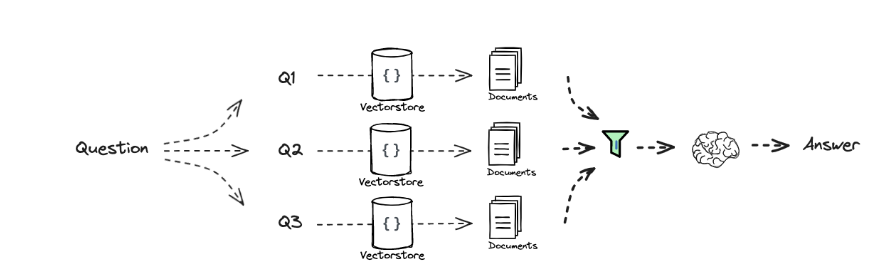

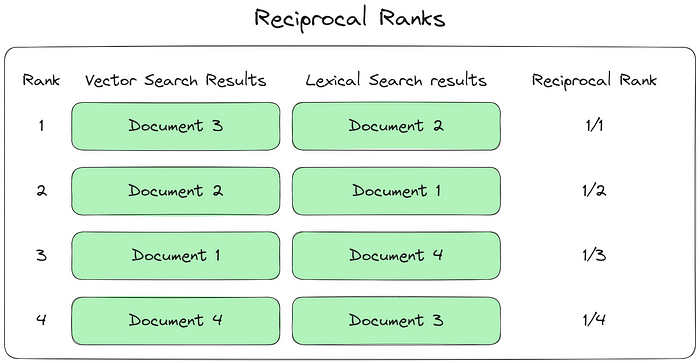

In [107]:
prompt1 = ChatPromptTemplate.from_messages([
     ("system","""You are a helpful assistant that generates multiple search queries
     based on a single input."""),
     ("user", "Generate multiple search queries related to: {question}"),
     ("user", "Generate only questions and nothing else. OUTPUT (4 queries sperated by \n):")
 ])

In [108]:
def check_empty(string):
    if string == " " or not string:
        return False
    else:
        return True

def split_questions(questions):
    q = questions.split("\n")
    return list(filter(check_empty,q))

In [109]:
generate_queries = (
    prompt1 | chat_model | StrOutputParser() | RunnableLambda(split_questions)
)

In [110]:
generate_queries.invoke({"question":"What is Deep seek R1? explain in short"})

['What is Deep Seek R1 : ',
 'What does Deep Seek R1 do : ',
 'How does Deep Seek R1 work : ',
 'What are the features of Deep Seek R1 :']

In [111]:
from langchain.load import dumps, loads


def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return " ".join([doc.page_content for doc, score in reranked_results])

In [112]:
fusion_chain = generate_queries | retriever.map() | reciprocal_rank_fusion

In [113]:
fusion_chain.invoke({"question":"""What is Deep seek R1? explain in short"""})

<ipython-input-111-7ae5ef1dc199>:15: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


'the competition. For engineering-related tasks, DeepSeek-R1 performs slightly better than\nDeepSeek-V3, which could help developers in real world tasks.\n• Knowledge: On benchmarks such as MMLU, MMLU-Pro, and GPQA Diamond, DeepSeek-\nR1 achieves outstanding results, significantly outperforming DeepSeek-V3 with scores\nof 90.8% on MMLU, 84.0% on MMLU-Pro, and 71.5% on GPQA Diamond. While its\nperformance is slightly below that of OpenAI-o1-1217 on these benchmarks, DeepSeek-R1\nsurpasses other closed-source models, demonstrating its competitive edge in educational\ntasks. On the factual benchmark SimpleQA, DeepSeek-R1 outperforms DeepSeek-V3,\ndemonstrating its capability in handling fact-based queries. A similar trend is observed\nwhere OpenAI-o1 surpasses 4o on this benchmark.\n4 tuned models based on the same underlying checkpoints.\nIn the future, we plan to invest in research across the following directions for DeepSeek-R1.\n• General Capability:Currently, the capabilities of Deep

In [114]:
gen_template = """
            You are a helpful, respectful and honest assistant designated answer questions.
            Answer the question based only on the following context.
            Context :{context}
            Question: {question}
           """
gen_prompt = ChatPromptTemplate.from_template(gen_template)

In [115]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

In [116]:
setup_retrieve = RunnableParallel(
    {
        "context":fusion_chain,
        "question":RunnablePassthrough()
    }
)

In [117]:
RAG_fusion_chain = setup_retrieve|gen_prompt|chat_model|StrOutputParser()

In [118]:
RAG_fusion_chain.invoke({"question":"What is Deep seek R1? explain in short"})

'DeepSeek-R1 is a model that achieves outstanding results in various tasks, including educational and factual benchmarks, outperforming other models like DeepSeek-V3 in many areas. It has strong reasoning capabilities, excels in tasks like creative writing, question answering, and editing, and demonstrates a competitive edge in handling fact-based queries.'